In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *

### 0 step. Function 

In [14]:
def gaussian_func(x, *, amp:float=1.0, ave:float=0, std:float=1.0):
    """ガウス関数
    Args:
        amp(float): 振幅
        ave(float): 平均
        std(float): 標準偏差
    Returns:
        gaussian function(float)
    """
    return amp*np.exp(-1*((x - ave)/2*std)**2)

In [15]:
def rmse(true:list, prediction:list) -> np.ndarray:
  return np.sqrt(mean_squared_error(true, prediction))

In [31]:
def _accuracy_rmse_func(true_list:list, asses_list:list, num_elem:int) -> list:
  """RMSEリストの作成
  Args:
      true_list(list): 今回の実験の真値
      asses_list(list): 真値との差を図りたいリスト
      num_elem(int): 真値との差を図りたい変数の数
  Returns:
      rmse_list(list): タイムステップ別に分けたrmse
  Note:
    シミュレーション値, データ同化値と観測値では, RMSEのタイムリストや変数の数が違うので注意。
  """
  rmse_list  = []
  time_range = len(true_list[0])
  
  for i_num in range(time_range):
    rmse_true_list , rmse_asses_list= [], []
    for i_elem in range(num_elem):
      rmse_true_list.append(true_list[i_elem][i_num])
      rmse_asses_list.append(asses_list[i_elem][i_num])
    _rmse = rmse(rmse_true_list, rmse_asses_list)
    rmse_list.append(_rmse)
  
  return rmse_list

In [28]:
def _enkf_pathset(mem:int, method_num:int, *, outdir:str='./output/lorenz63/') -> str:
  """EnKFのPATH設定

  Args:
      mem(int): EnKFのメンバー数
      method_num(int): 0はPO法、1はSRF法

  Keyword Arguments:
      outdir(str): PATHの大元設定。変更なければ引数に加えなくて良い。 (default: {'./output/lorenz63'})

  Returns:
      enkf_data_path(str):  enkfのデータPATH
      enkf_errcov_path(str):  enkfの誤差共分散データPATH
  """
  enkf_method = ['PO', 'SRF']
  enkf_data_path = outdir+'EnKF_'+str(mem)+'m_'+enkf_method[method_num]+'.csv'
  enkf_errcov_path = outdir+'errcov_EnKF_'+str(mem)+'m_'+enkf_method[method_num]+'.csv'
  return enkf_data_path, enkf_errcov_path

In [29]:
def _df2list(Dataframe:pd.core.frame.DataFrame, *index_wrd:tuple) -> list:
    """pandasフレームをリスト化

    Args:
      Dataframe(pd.core.frame.DataFrame): リスト化したいデータフレーム
      index_wrd(tuple): 抽出したいコラム名

    Returns:
      index_list(list): pandasフレームを指定されたコラム名で抽出したリスト
    """
    index_list = []
    for i_index in index_wrd:
      index_list.append(Dataframe[i_index].tolist())
    return index_list

### 1step. Prepare Data SET (Lorenz63)

In [19]:
outdir = './output/lorenz63/'
path_kf, path_kf_errcov = outdir+'KF.csv', outdir+'errcov_KF.csv'

In [20]:
df  = pd.read_csv(path_kf, sep=',', comment='#', skiprows=2)
time_list = _df2list(df, ' timestep')[0]
true_list = _df2list(df, ' x_true', ' y_true', ' z_true')
undef = -999.e0
    
# obs. list
obs = df.loc[ :, [' timestep', ' x_true', ' y_true', ' z_true', ' x_obs', ' y_obs', ' z_obs']]
obs = obs[obs[' x_obs'] != undef]
obs_time_list = _df2list(obs, ' timestep')[0]
obs_true_list = _df2list(obs, ' x_true', ' y_true', ' z_true')
obs_list      = _df2list(obs, ' x_obs', ' y_obs', ' z_obs')
    
# sim. list
sim_list  = _df2list(df, ' x_sim', ' y_sim', ' z_sim')
da_list   = _df2list(df, ' x_anl', ' y_anl', ' z_anl')

### 2nd step. RMSE

In [32]:
num_sim_elem, num_obs_elem = 3, 3
rmse_sim = _accuracy_rmse_func(true_list, sim_list, num_sim_elem)
rmse_kf    = _accuracy_rmse_func(true_list, da_list, num_sim_elem)
rmse_obs = _accuracy_rmse_func(obs_true_list, obs_list, num_obs_elem)

### 3rd step. Result

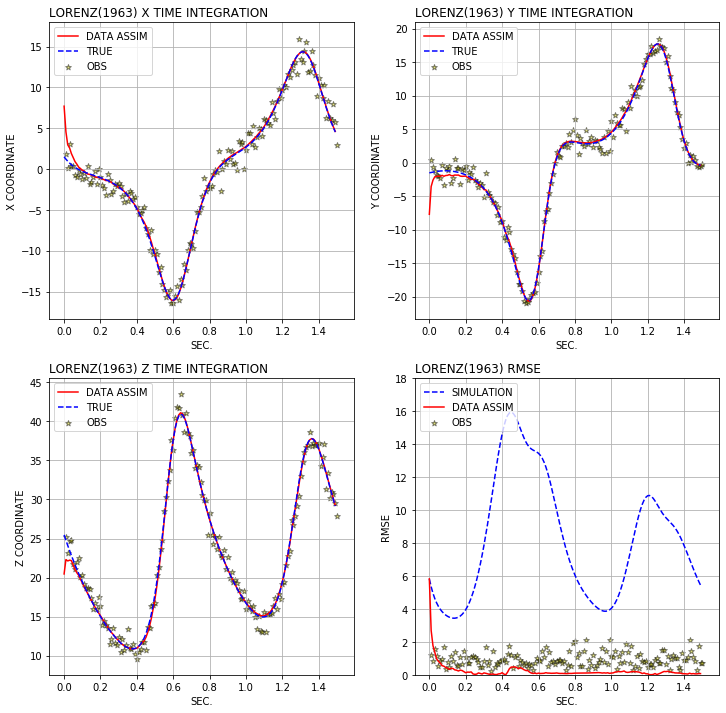

In [75]:
fig, ax = plt.subplots(2,2,figsize=(12,12))

# set parm
time_length = 150

# ax[0,0] = x
x_ax = ax[0,0]
x_ax.plot(time_list[0:time_length], da_list[0][0:time_length], color='r', ls='-', label='DATA ASSIM')
x_ax.plot(time_list[0:time_length], true_list[0][0:time_length], color='b', ls='--', label='TRUE')
x_ax.scatter(obs_time_list[0:time_length], obs_list[0][0:time_length],  marker='*', color='y', edgecolor='k', s=35, alpha=0.5, label='OBS')
x_ax.set_xlabel('SEC.')
x_ax.set_ylabel('X COORDINATE')
x_ax.set_title('LORENZ(1963) X TIME INTEGRATION', loc='left')
x_ax.grid()
x_ax.legend(loc='upper left')


# ax[0,1] = y
y_ax = ax[0,1]
y_ax.plot(time_list[0:time_length], da_list[1][0:time_length], color='r', ls='-', label='DATA ASSIM')
y_ax.plot(time_list[0:time_length], true_list[1][0:time_length], color='b', ls='--', label='TRUE')
y_ax.scatter(obs_time_list[0:time_length], obs_list[1][0:time_length],  marker='*', color='y', edgecolor='k', s=35, alpha=0.5, label='OBS')
y_ax.set_xlabel('SEC.')
y_ax.set_ylabel('Y COORDINATE')
y_ax.set_title('LORENZ(1963) Y TIME INTEGRATION', loc='left')
y_ax.grid()
y_ax.legend(loc='upper left')


# ax[1,0] = z
z_ax = ax[1,0]
z_ax.plot(time_list[0:time_length], da_list[2][0:time_length], color='r', ls='-', label='DATA ASSIM')
z_ax.plot(time_list[0:time_length], true_list[2][0:time_length], color='b', ls='--', label='TRUE')
z_ax.scatter(obs_time_list[0:time_length], obs_list[2][0:time_length],  marker='*', color='y', edgecolor='k', s=35, alpha=0.5, label='OBS')
z_ax.set_xlabel('SEC.')
z_ax.set_ylabel('Z COORDINATE')
z_ax.set_title('LORENZ(1963) Z TIME INTEGRATION', loc='left')
z_ax.grid()
z_ax.legend(loc='upper left')


#ax[1,1] = RMSE
rmse_ax = ax[1,1]
rmse_ax.plot(time_list[0:time_length], rmse_sim[0:time_length], ls="--", color='b', label='SIMULATION')
rmse_ax.plot(time_list[0:time_length], rmse_kf[0:time_length], ls="-", color='r', label='DATA ASSIM')
rmse_ax.scatter(obs_time_list[0:time_length], rmse_obs[0:time_length], marker='*', color='y', s=35, alpha=0.5, edgecolor='k', label='OBS')
rmse_ax.set_xlabel('SEC.')
rmse_ax.set_ylabel('RMSE')
rmse_ax.set_ylim(0, 18)
rmse_ax.set_title('LORENZ(1963) RMSE', loc='left')
rmse_ax.grid()
rmse_ax.legend(loc='upper left')
